In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cluster import DBSCAN
#importing and reading the dataset and data exploration
df= pd.read_csv('ObesityDataSet.csv')

In [3]:
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

null_cols = null_check(df)

Column Name: Gender
Column DataType: object
Column unique values: ['Female' 'Male']
Column has null: False


Column Name: Age
Column DataType: float64
Column has null: False


Column Name: Height
Column DataType: float64
Column has null: False


Column Name: Weight
Column DataType: float64
Column has null: False


Column Name: family_history_with_overweight
Column DataType: object
Column unique values: ['yes' 'no']
Column has null: False


Column Name: FAVC
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: FCVC
Column DataType: float64
Column has null: False


Column Name: NCP
Column DataType: float64
Column has null: False


Column Name: CAEC
Column DataType: object
Column unique values: ['Sometimes' 'Frequently' 'Always' 'no']
Column has null: False


Column Name: SMOKE
Column DataType: object
Column unique values: ['no' 'yes']
Column has null: False


Column Name: CH2O
Column DataType: float64
Column has null: False


Column Name: SCC
C

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
# displaying data types, null values, and possible outliers in each column
def dataframe_summary():
    
    # lists
    var_list = df.columns.to_list()
    dtype_list = []
    null_list = []
    
    # looping through columns
    for col in df.columns:
        dtype_list.append(df[col].dtype)
        null_list.append(df[col].isnull().sum())
    
    # outliers IQR
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    IQR = Q3 - Q1
    k = 1.5
    outlier_list = ((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).sum().to_list()
    
    # stacking lists into dictionary
    dict = {'Variable': var_list, 'Data type': dtype_list, 'Null values': null_list, 'Outliers': outlier_list}
    
    return pd.DataFrame(dict).style.hide_index()
    
dataframe_summary()

C:\Users\lenovo1\AppData\Local\Temp\ipykernel_8744\3884873115.py:17: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(.25)
C:\Users\lenovo1\AppData\Local\Temp\ipykernel_8744\3884873115.py:18: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(.75)
C:\Users\lenovo1\AppData\Local\Temp\ipykernel_8744\3884873115.py:21: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outlier_list = ((df < (Q1 - k * IQR)) | (df > (Q3 + k * IQR))).sum().to_list()
C:\Us

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd

# Function to handle missing values
def missing_value_treatment(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]  # Preserve target column separately
        df = df.drop(columns=[target])
    else:
        target_data = None
    
    missing_columns = df.columns[df.isna().any()].tolist()
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = list(set(df.columns) - set(numerical_cols))
    
    for col in missing_columns:
        missing_ratio = df[col].isna().sum() / len(df)
        if missing_ratio <= 0.05 and len(df) > 30000:
            df.dropna(subset=[col], inplace=True)
        elif missing_ratio > 0.8:
            df.drop(columns=[col], inplace=True)
        else:
            if col in categorical_cols:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
            else:
                imputer = IterativeImputer(max_iter=10, random_state=0)
                imputed_data = imputer.fit_transform(df[numerical_cols])
                df[numerical_cols] = pd.DataFrame(imputed_data, columns=numerical_cols)

    df.reset_index(drop=True, inplace=True)
    if target_data is not None:
        df[target] = target_data  # Reattach target column after processing
    print("Missing values treated successfully.")
    return df

# Function to handle duplicate values
def duplicate_value_treatment(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    initial_count = len(df)
    df.drop_duplicates(inplace=True)
    final_count = len(df)
    df.reset_index(drop=True, inplace=True)
    
    if target_data is not None:
        df[target] = target_data
    print(f"Duplicate values removed: {initial_count - final_count}")
    return df

# Function to standardize numerical columns
def data_standardization(df, target, scaling_type=1):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    num_var = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    
    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        print("Invalid scaling type. Choose 1 (StandardScaler) or 2 (MinMaxScaler).")
        return df
    
    for col in num_var:
        df[col] = scaler.fit_transform(df[[col]]).round(2)
    
    if target_data is not None:
        df[target] = target_data
    print(f"Data standardized using {'StandardScaler' if scaling_type == 1 else 'MinMaxScaler'}.")
    return df

# Function to encode categorical columns
def cat_encoding(df, target):
    df = df.copy()
    if target in df.columns:
        target_data = df[target]
        df = df.drop(columns=[target])
    else:
        target_data = None

    cat_var = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    label_encoder = LabelEncoder()
    
    for col in cat_var:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    
    if target_data is not None:
        df[target] = target_data
    print("Categorical variables encoded successfully.")
    return df

# Main data preprocessing pipeline
def preprocess_data(df, target, scaling_type=1):
    print("Starting data preprocessing...")
    df = missing_value_treatment(df, target)
    df = duplicate_value_treatment(df, target)
    df = data_standardization(df, target, scaling_type)
    df = cat_encoding(df, target)
    print("Data preprocessing completed.")
    return df

# Example Usage:
target = "NObeyesdad"
df = preprocess_data(df, target, scaling_type=1)



Starting data preprocessing...
Missing values treated successfully.
Duplicate values removed: 24
Data standardized using StandardScaler.
Categorical variables encoded successfully.
Data preprocessing completed.


In [6]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [7]:
df.describe()

Gender          Age       Height       Weight  \
count  2087.000000  2087.000000  2087.000000  2087.000000   
mean      0.504073    -0.000005    -0.000072     0.000053   
std       0.500103     1.000206     1.000256     1.000281   
min       0.000000    -1.630000    -2.710000    -1.830000   
25%       0.000000    -0.700000    -0.780000    -0.800000   
50%       1.000000    -0.240000    -0.010000    -0.140000   
75%       1.000000     0.260000     0.720000     0.810000   
max       1.000000     5.760000     2.980000     3.290000   

       family_history_with_overweight         FAVC         FCVC          NCP  \
count                     2087.000000  2087.000000  2087.000000  2087.000000   
mean                         0.825108     0.883565    -0.001174    -0.000877   
std                          0.379966     0.320823     0.999936     1.001031   
min                          0.000000     0.000000    -2.660000    -2.230000   
25%                          1.000000     1.000000    -0.790000    -0.005000   
50%                          1.000000     1.000000    -0.050000     0.390000   
75%                          1.000000     1.000000     1.080000     0.390000   
max                          1.000000     1.000000     1.080000     1.700000   

              CAEC        SMOKE         CH2O          SCC          FAF  \
count  2087.000000  2087.000000  2087.000000  2087.000000  2087.000000   
mean      1.853857     0.021083    -0.000024     0.045999    -0.000762   
std       0.459494     0.143695     1.000335     0.209533     1.001415   
min       0.000000     0.000000    -1.650000     0.000000    -1.190000   
25%       2.000000     0.000000    -0.680000     0.000000    -1.040000   
50%       2.000000     0.000000    -0.010000     0.000000    -0.020000   
75%       2.000000     0.000000     0.755000     0.000000     0.780000   
max       3.000000     1.000000     1.640000     1.000000     2.330000   

               TUE         CALC       MTRANS  
count  2087.000000  2087.000000  2087.000000  
mean     -0.000470     2.270244     2.358888  
std       0.999864     0.517008     1.265402  
min      -1.090000     0.000000     0.000000  
25%      -1.090000     2.000000     3.000000  
50%      -0.050000     2.000000     3.000000  
75%       0.550000     3.000000     3.000000  
max       2.200000     3.000000     4.000000

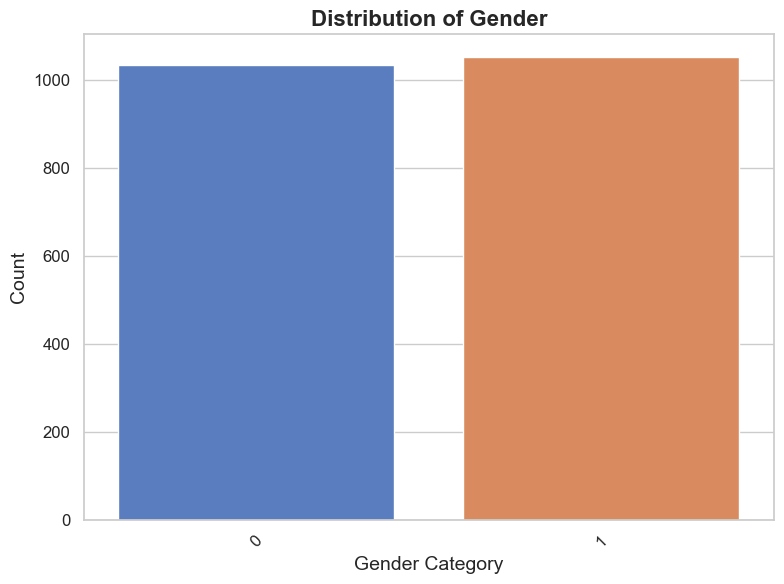

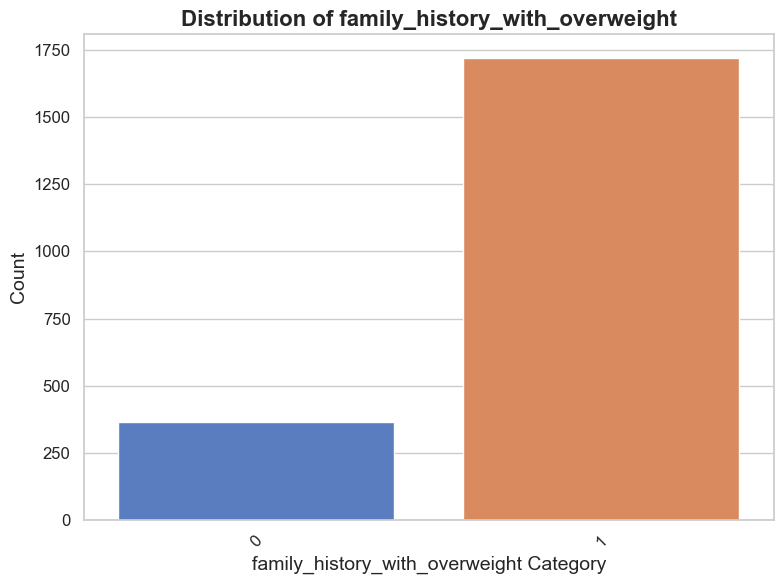

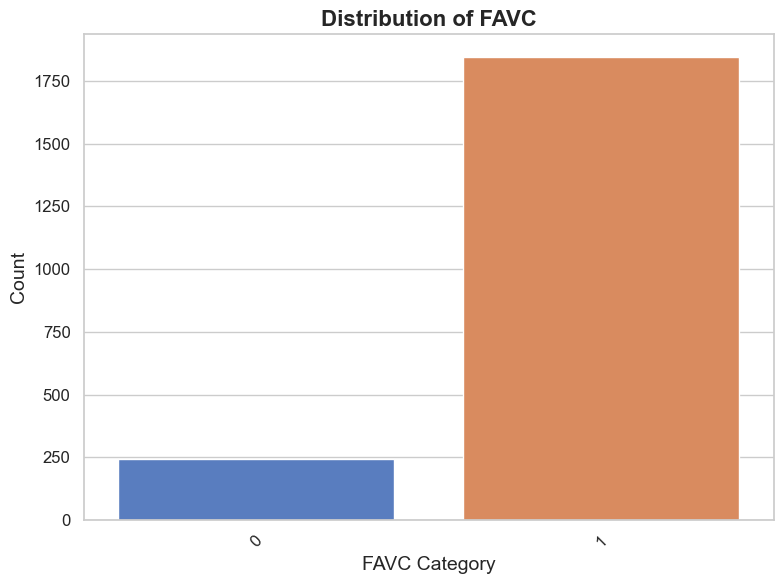

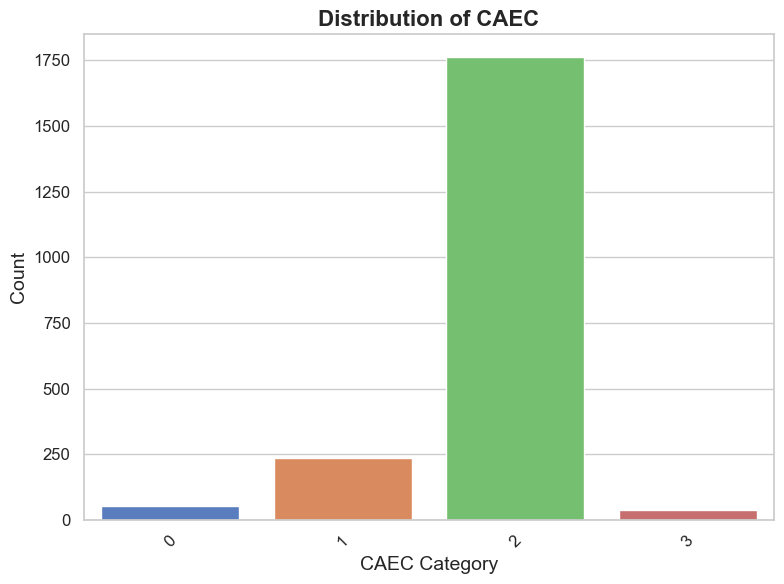

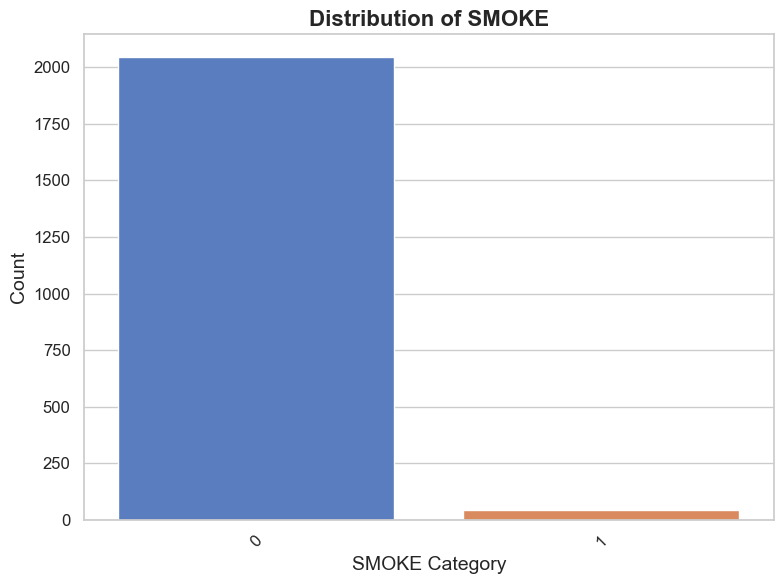

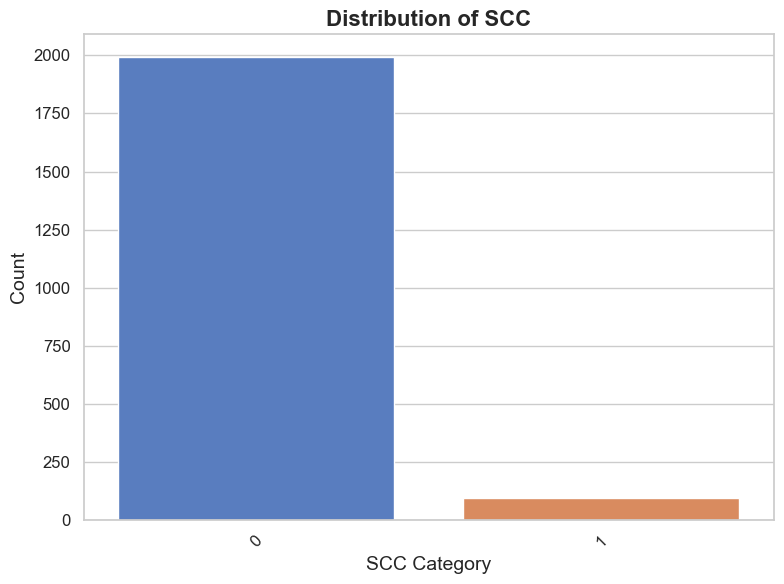

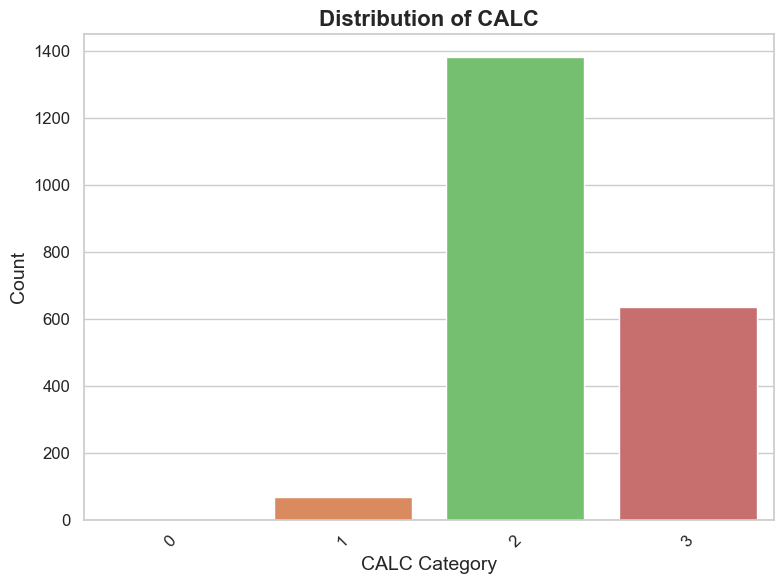

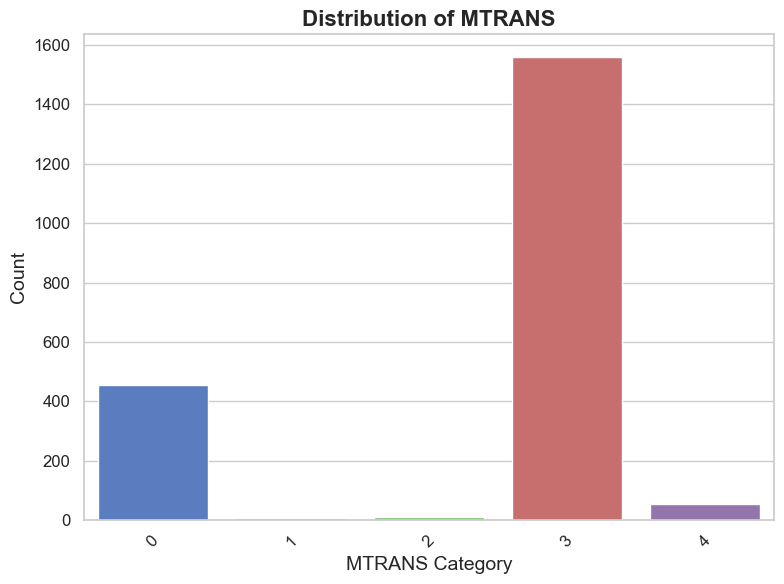

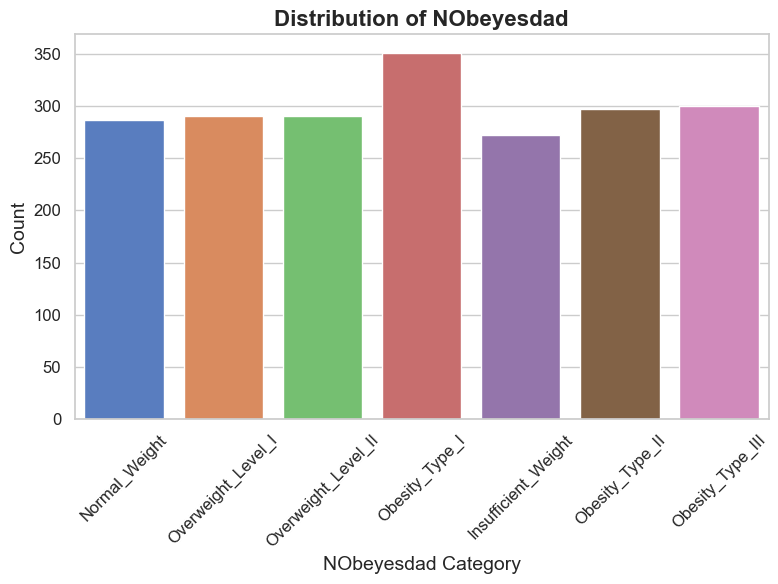

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through all the features and plot count plots
features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

for f in features:
    plt.figure(figsize=(8, 6))  # Increase figure size for better readability
    sns.countplot(x=f, data=df, palette='muted')  # Apply a muted palette for a balanced look
    
    # Add titles and labels
    plt.title(f'Distribution of {f}', fontsize=16, weight='bold')
    plt.xlabel(f'{f} Category', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Rotate x-axis labels for better readability and adjust label size
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


# CATEGORICAL DATA 

<Figure size 800x600 with 0 Axes>

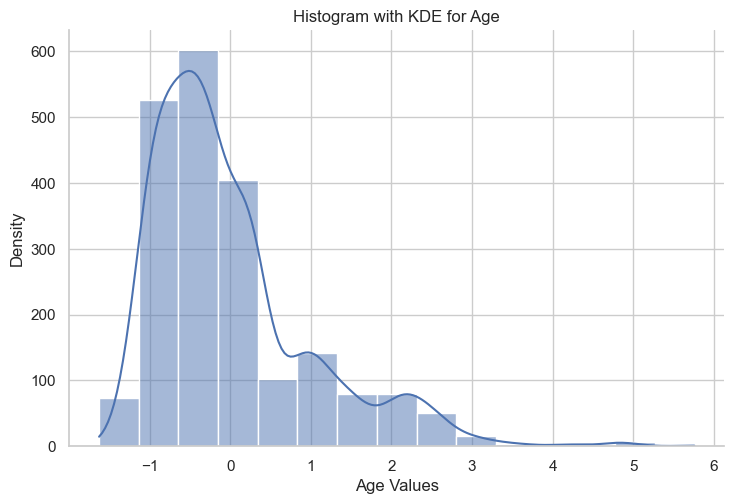

<Figure size 800x600 with 0 Axes>

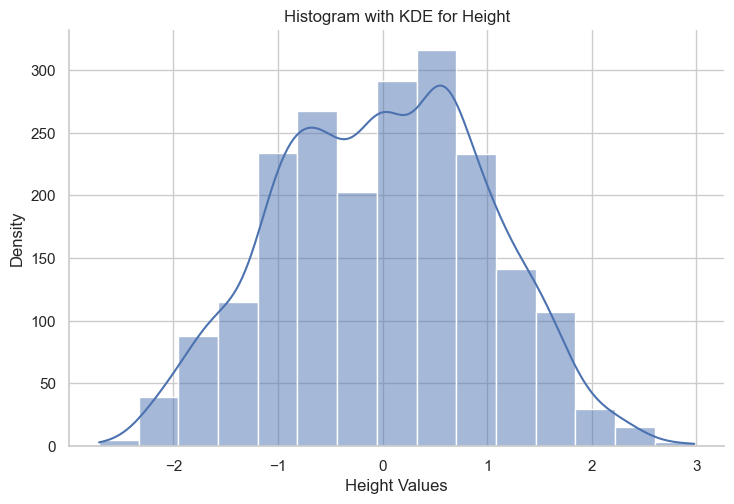

<Figure size 800x600 with 0 Axes>

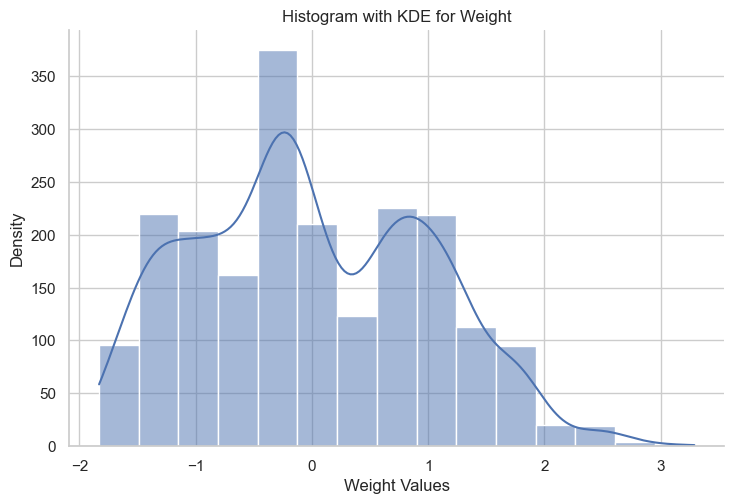

<Figure size 800x600 with 0 Axes>

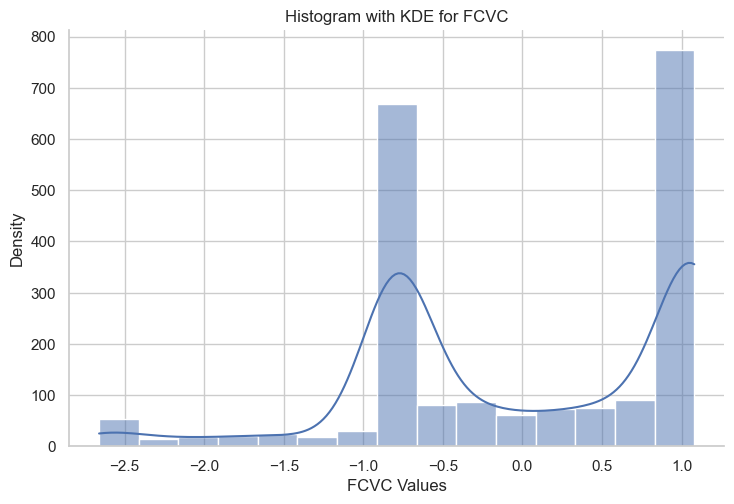

<Figure size 800x600 with 0 Axes>

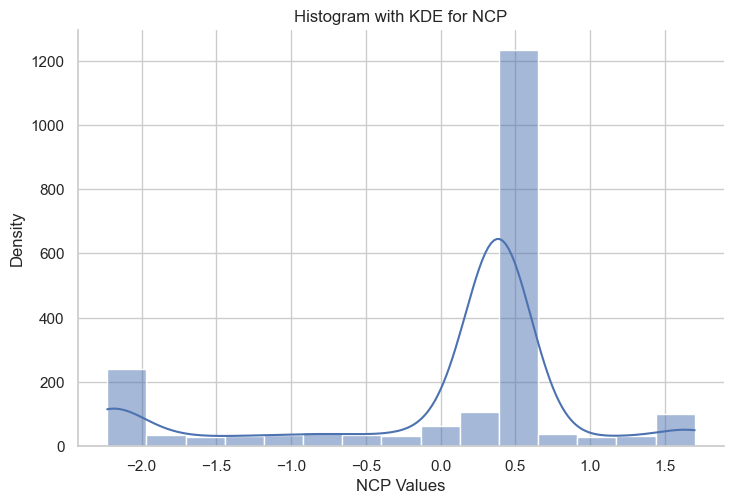

<Figure size 800x600 with 0 Axes>

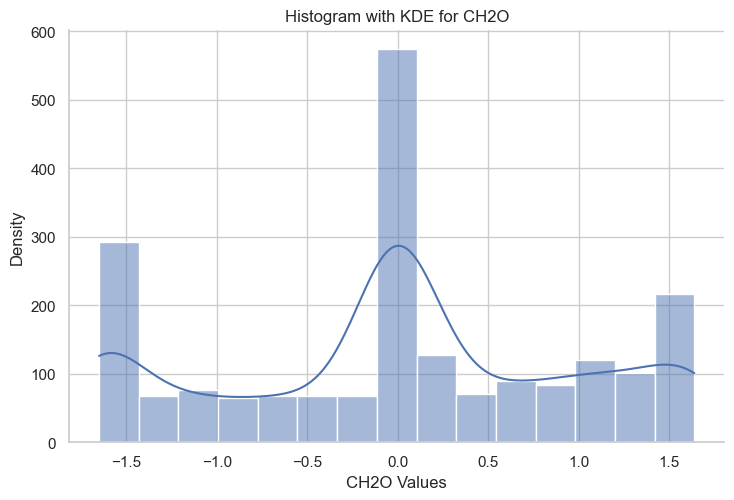

<Figure size 800x600 with 0 Axes>

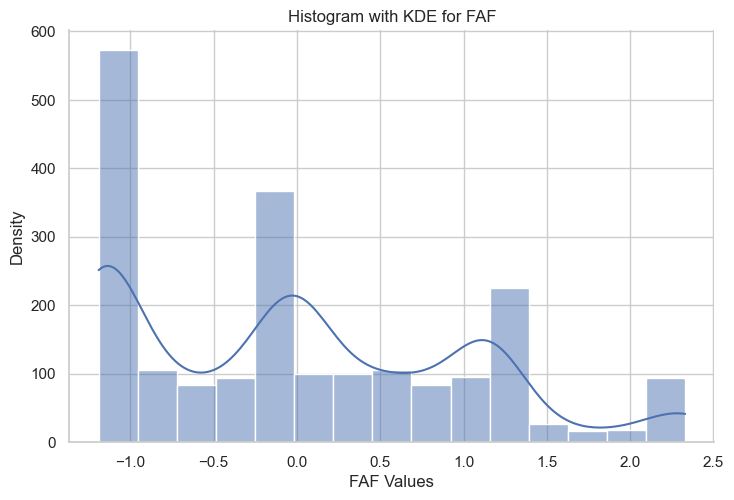

<Figure size 800x600 with 0 Axes>

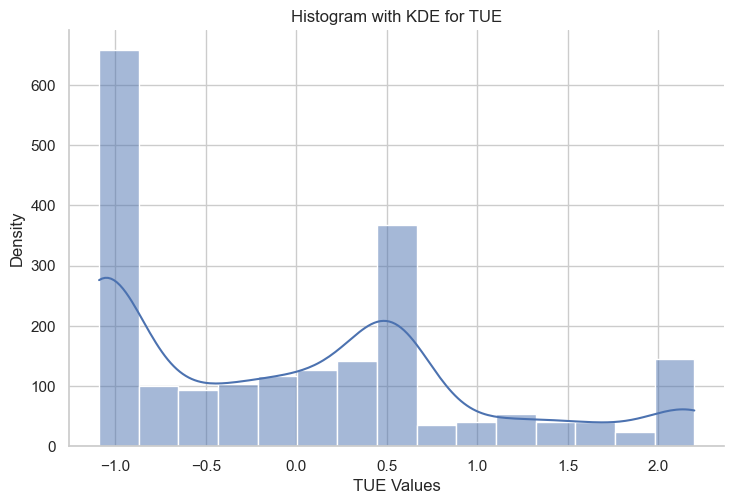

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is a DataFrame containing the features
# Example data (replace 'data' with your actual DataFrame)
num_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']  # List of numeric features

# Plot histogram with KDE for each feature in the 'num_features' list
for feature in num_features:
    plt.figure(figsize=(8, 6))
    sns.displot(df[feature], kde=True, bins=15, aspect=1.5)
    
    # Set titles and labels
    plt.title(f"Histogram with KDE for {feature}")
    plt.xlabel(f"{feature} Values")
    plt.ylabel("Density")
    
    # Display the plot
    plt.show()


# FEATURE SCALING

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import pandas as pd

def data_standardization(df, scaling_type=1):
    df = df.copy()
    num_var = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    if scaling_type == 1:
        scaler = StandardScaler()
    elif scaling_type == 2:
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling_type. Use 1 for StandardScaler or 2 for MinMaxScaler.")
    df[num_var] = scaler.fit_transform(df[num_var]).round(2)
    return df

def cat_encoding(df):
    df = df.copy()
    cat_var = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col])]
    label_encoder = LabelEncoder()
    for feature in cat_var:
        df[feature] = label_encoder.fit_transform(df[feature])
    return df

df = cat_encoding(df)
df = data_standardization(df, scaling_type=2)


# PCA AND TSNE

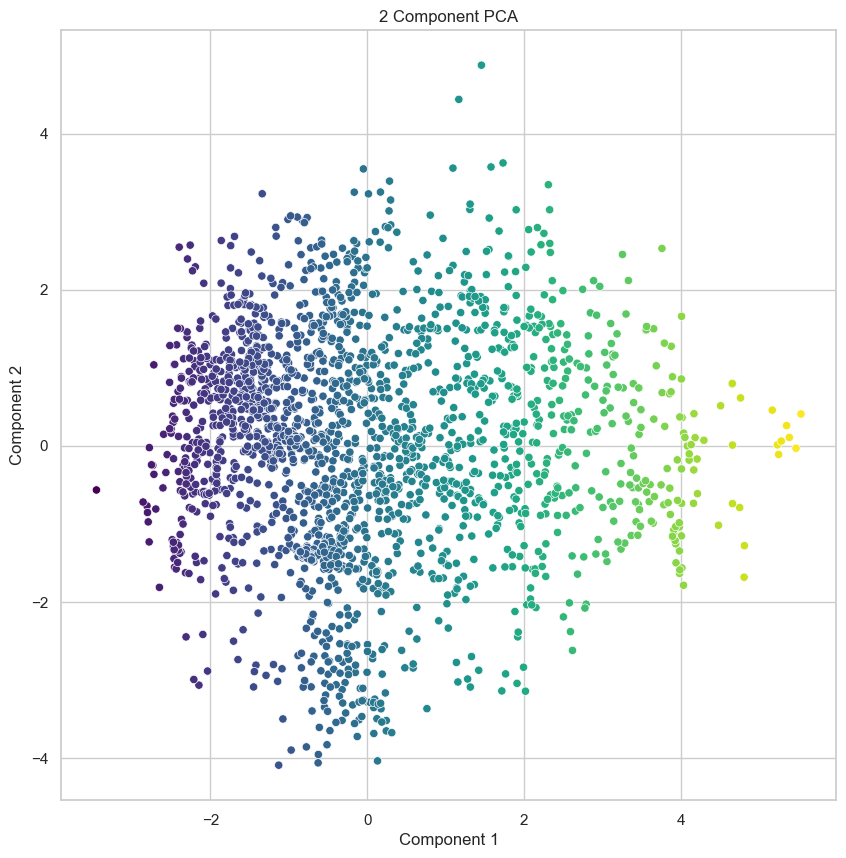

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2087 samples in 0.000s...
[t-SNE] Computed neighbors for 2087 samples in 0.388s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2087
[t-SNE] Computed conditional probabilities for sample 2000 / 2087
[t-SNE] Computed conditional probabilities for sample 2087 / 2087
[t-SNE] Mean sigma: 0.850824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.280838
[t-SNE] KL divergence after 300 iterations: 1.331617


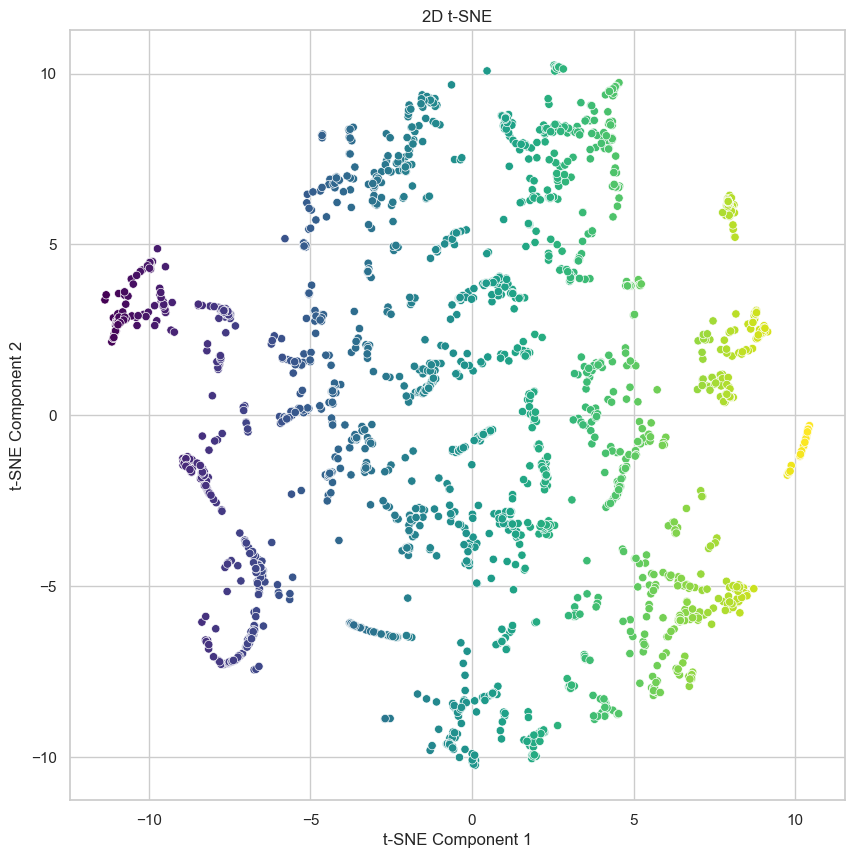

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2087 samples in 0.001s...
[t-SNE] Computed neighbors for 2087 samples in 0.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2087
[t-SNE] Computed conditional probabilities for sample 2000 / 2087
[t-SNE] Computed conditional probabilities for sample 2087 / 2087
[t-SNE] Mean sigma: 0.850824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.089294
[t-SNE] KL divergence after 300 iterations: 1.122046


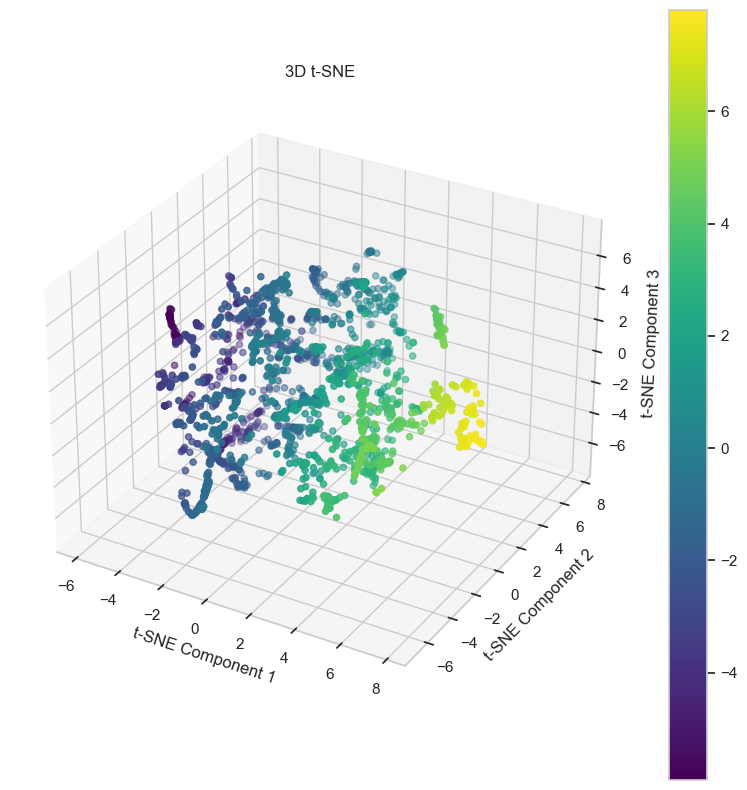

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

def scale_data(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

def pca_2d_visualization(df_scaled):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df_scaled)
    PCA_dataset = pd.DataFrame(data=principalComponents, columns=['component1', 'component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2 Component PCA')
    sns.scatterplot(x='component1', y='component2', data=PCA_dataset, palette='viridis', hue='component1', legend=False)
    plt.show()

def tsne_2d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2'])
    plt.figure(figsize=(10, 10))
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title('2D t-SNE')
    sns.scatterplot(x='tsne_component1', y='tsne_component2', data=TSNE_dataset, palette='viridis', hue='tsne_component1', legend=False)
    plt.show()

def tsne_3d_visualization(df_scaled, perplexity=40, n_iter=300):
    tsne = TSNE(n_components=3, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(df_scaled)
    TSNE_dataset = pd.DataFrame(data=tsne_results, columns=['tsne_component1', 'tsne_component2', 'tsne_component3'])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('3D t-SNE')
    scatter = ax.scatter(xs=TSNE_dataset['tsne_component1'], 
                         ys=TSNE_dataset['tsne_component2'], 
                         zs=TSNE_dataset['tsne_component3'], 
                         c=TSNE_dataset['tsne_component1'], 
                         cmap='viridis')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    plt.colorbar(scatter)
    plt.show()
df_scaled = scale_data(df)
pca_2d_visualization(df_scaled)
tsne_2d_visualization(df_scaled)
tsne_3d_visualization(df_scaled)



Applying DBSCAN with eps=0.3 and min_samples=3
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


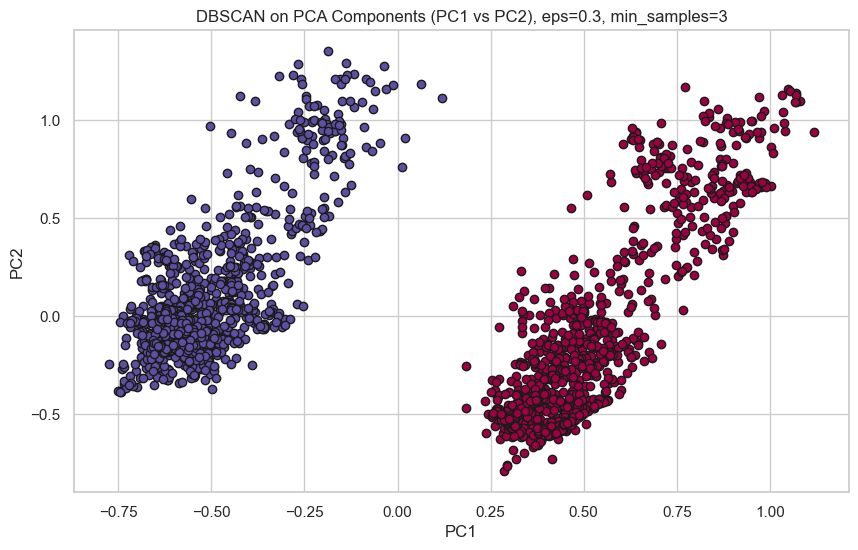


Applying DBSCAN with eps=0.3 and min_samples=6
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


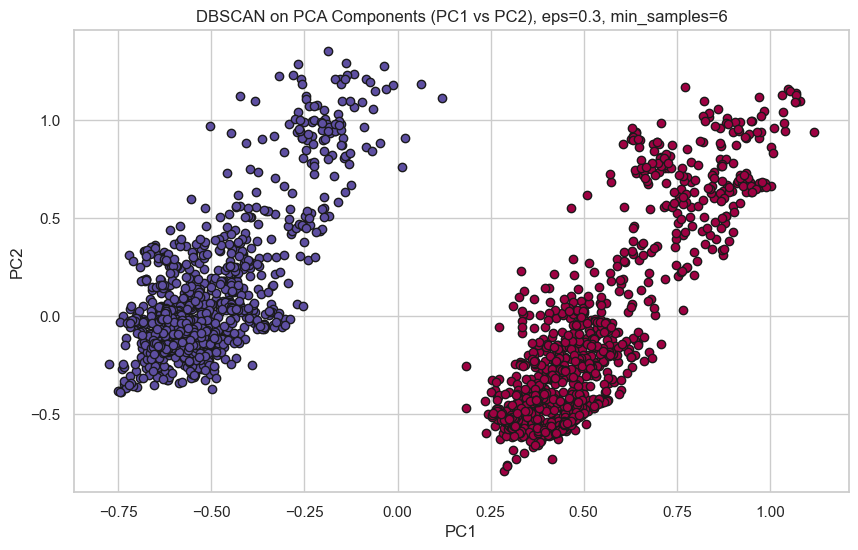


Applying DBSCAN with eps=0.3 and min_samples=8
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


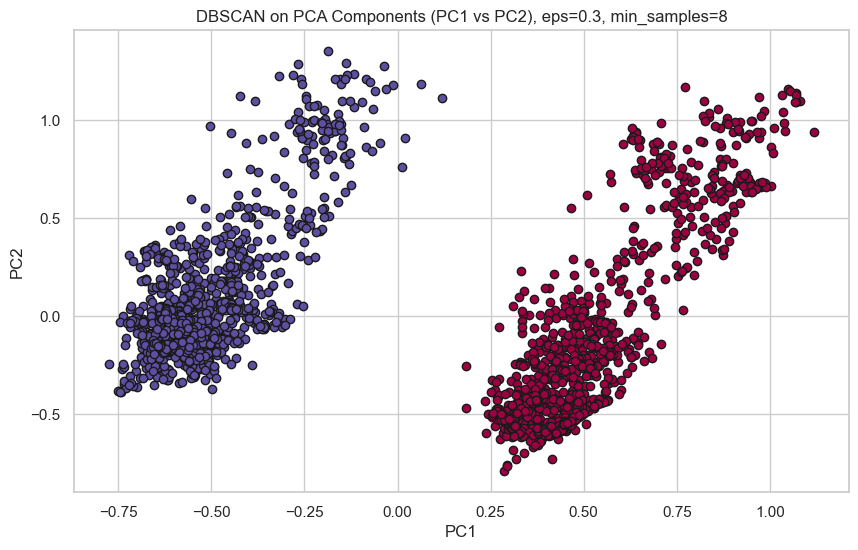


Applying DBSCAN with eps=0.3 and min_samples=10
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


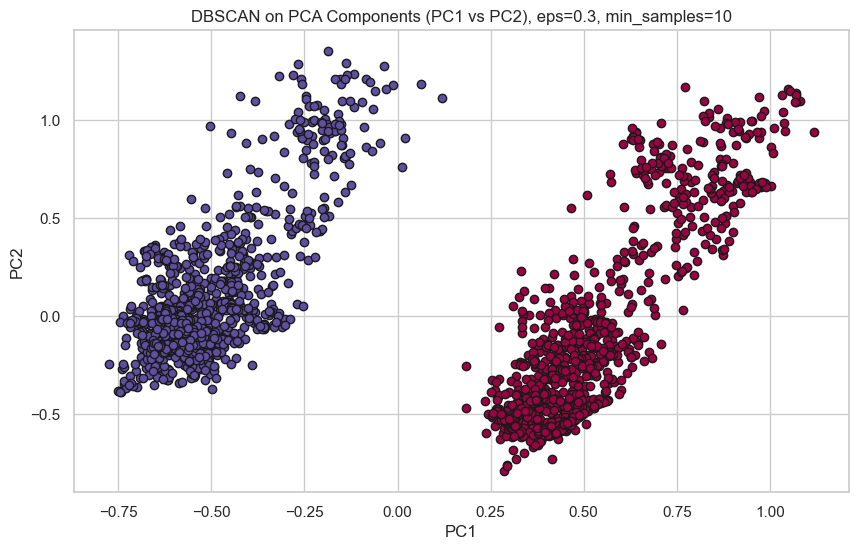


Applying DBSCAN with eps=0.5 and min_samples=3
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


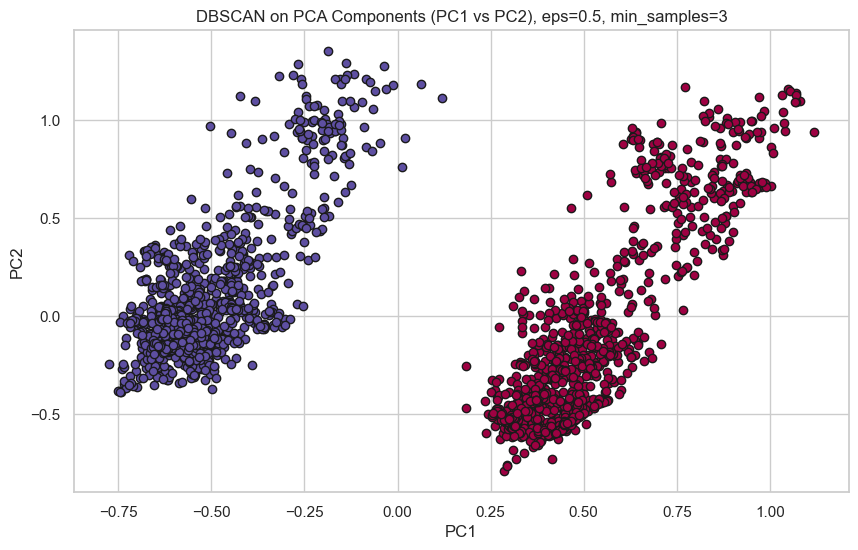


Applying DBSCAN with eps=0.5 and min_samples=6
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


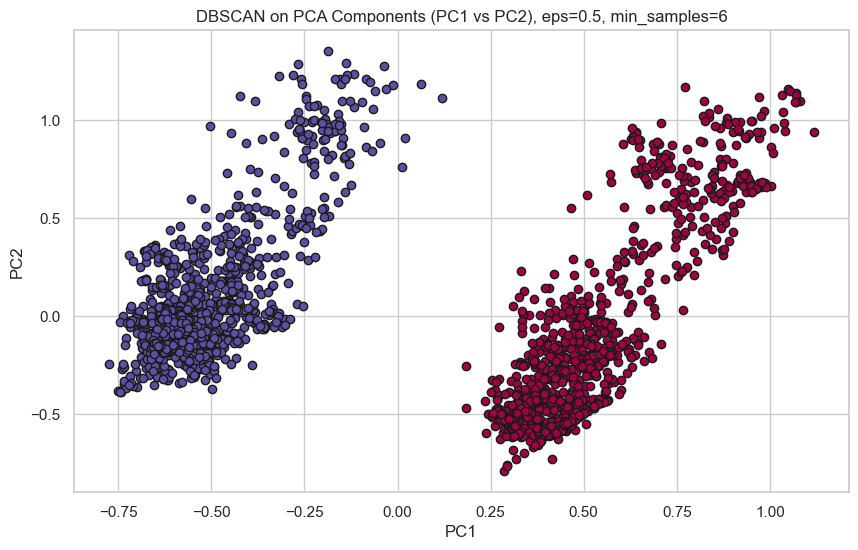


Applying DBSCAN with eps=0.5 and min_samples=8
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


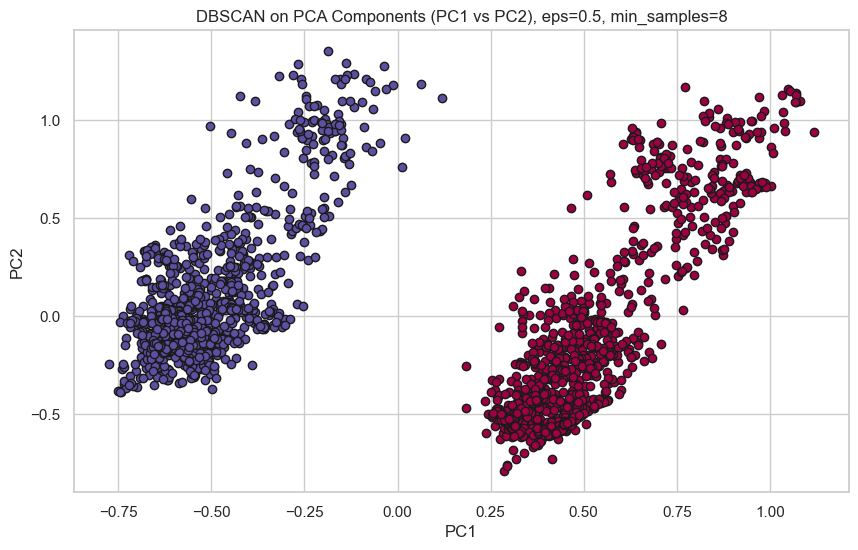


Applying DBSCAN with eps=0.5 and min_samples=10
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


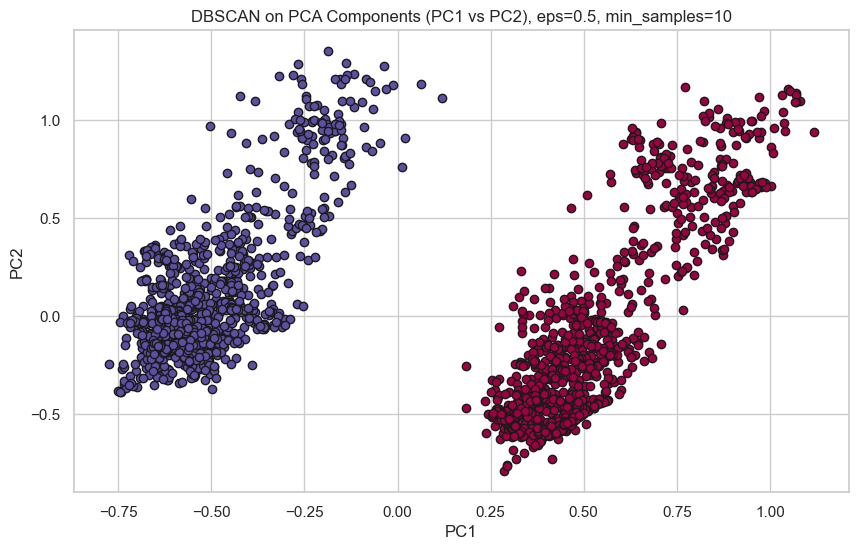


Applying DBSCAN with eps=1.7 and min_samples=3
Unique Cluster Labels (including noise): [0]
0    2087
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 1
Not enough clusters to calculate metrics.


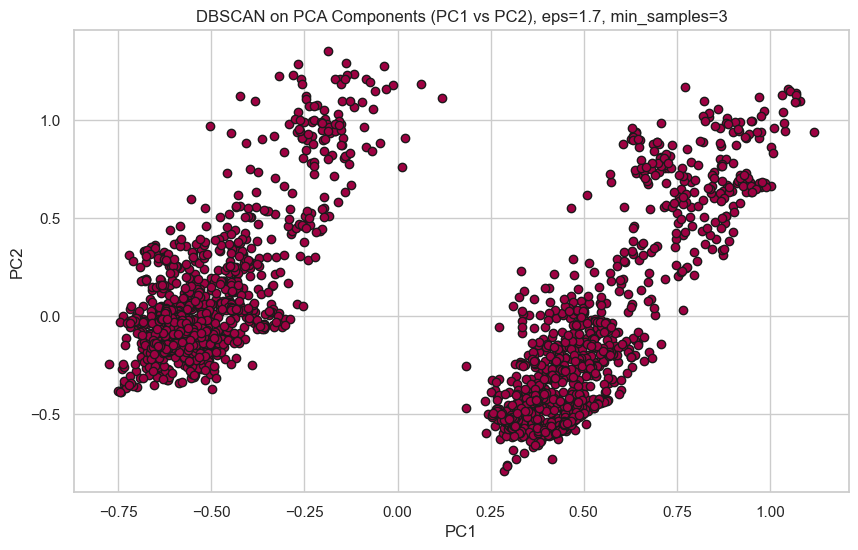


Applying DBSCAN with eps=1.7 and min_samples=6
Unique Cluster Labels (including noise): [0]
0    2087
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 1
Not enough clusters to calculate metrics.


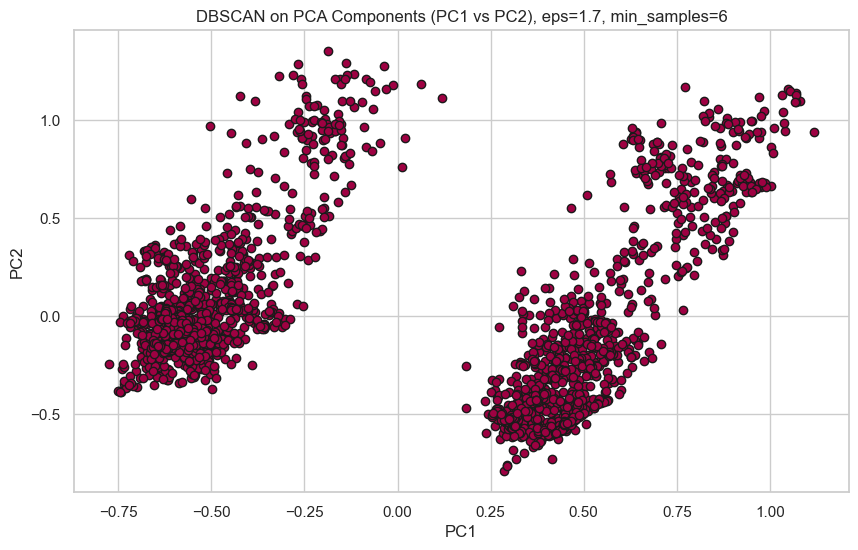


Applying DBSCAN with eps=1.7 and min_samples=8
Unique Cluster Labels (including noise): [0]
0    2087
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 1
Not enough clusters to calculate metrics.


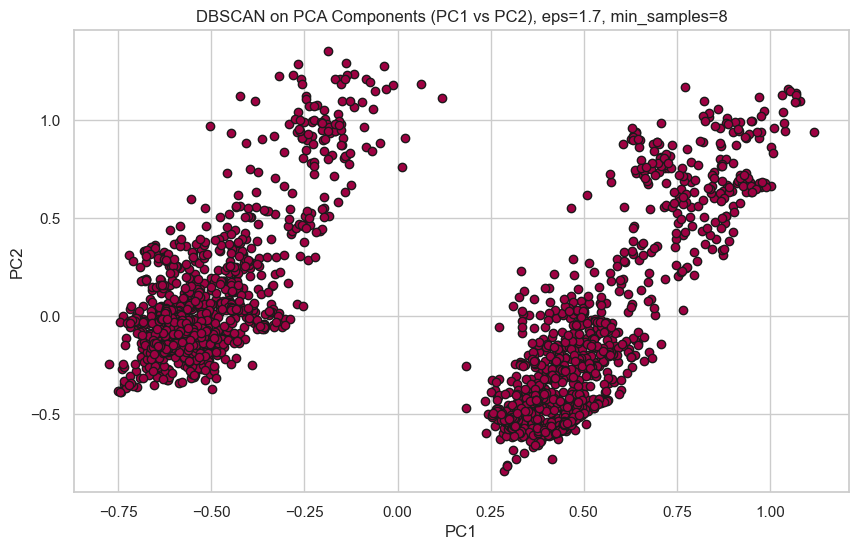


Applying DBSCAN with eps=1.7 and min_samples=10
Unique Cluster Labels (including noise): [0]
0    2087
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 1
Not enough clusters to calculate metrics.


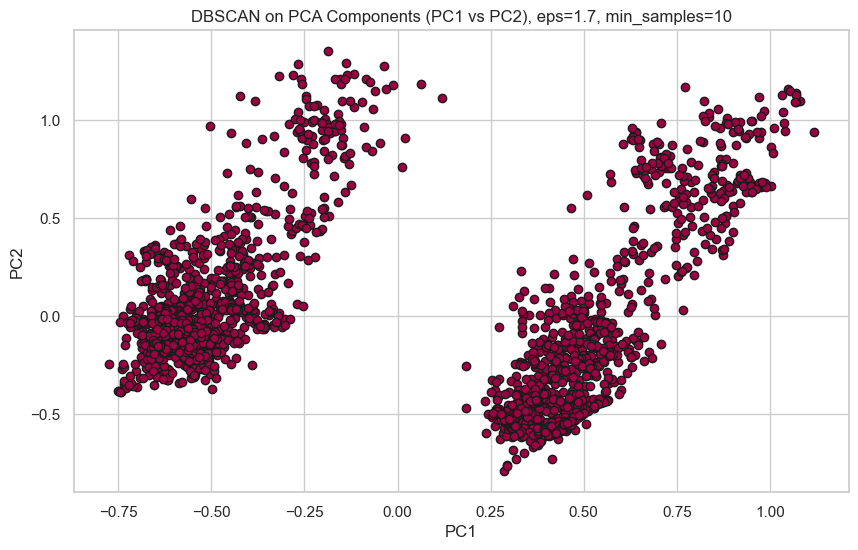


Applying DBSCAN with eps=0.025 and min_samples=3
Unique Cluster Labels (including noise): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59]
 3     691
 4     451
-1     293
 2     240
 10     42
      ... 
 18      3
 28      3
 29      3
 1       3
 59      3
Name: Cluster, Length: 61, dtype: int64
Number of Clusters (excluding noise): 60
Silhouette Score: 0.0185
Davies-Bouldin Index: 1.1017
Calinski-Harabasz Index: 157.7165


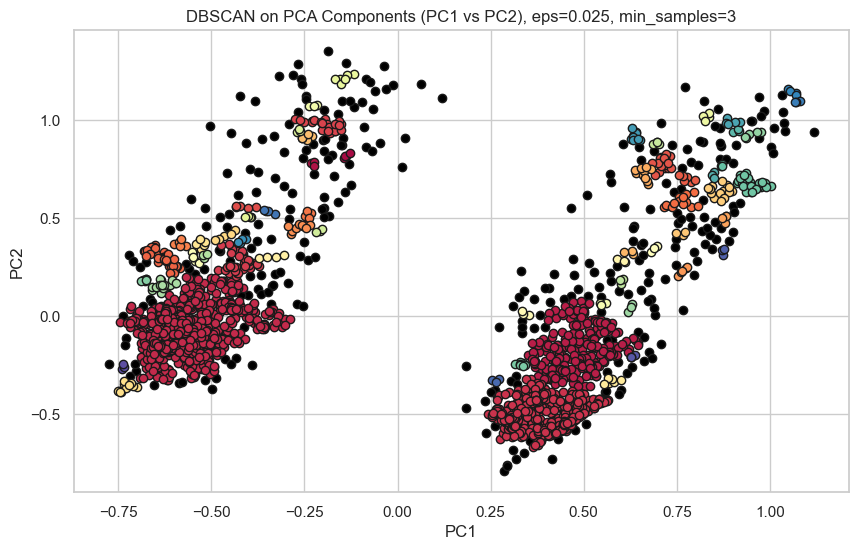


Applying DBSCAN with eps=0.025 and min_samples=6
Unique Cluster Labels (including noise): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]
 3     599
-1     580
 4     438
 2     105
 0      55
 11     31
 5      27
 1      26
 8      21
 6      16
 18     15
 9      15
 10     14
 19     14
 25     13
 28     13
 22     11
 26      9
 7       9
 13      9
 23      8
 20      8
 27      8
 16      7
 17      7
 12      7
 14      6
 24      6
 21      6
 15      4
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 29
Silhouette Score: -0.0607
Davies-Bouldin Index: 1.0830
Calinski-Harabasz Index: 149.2970


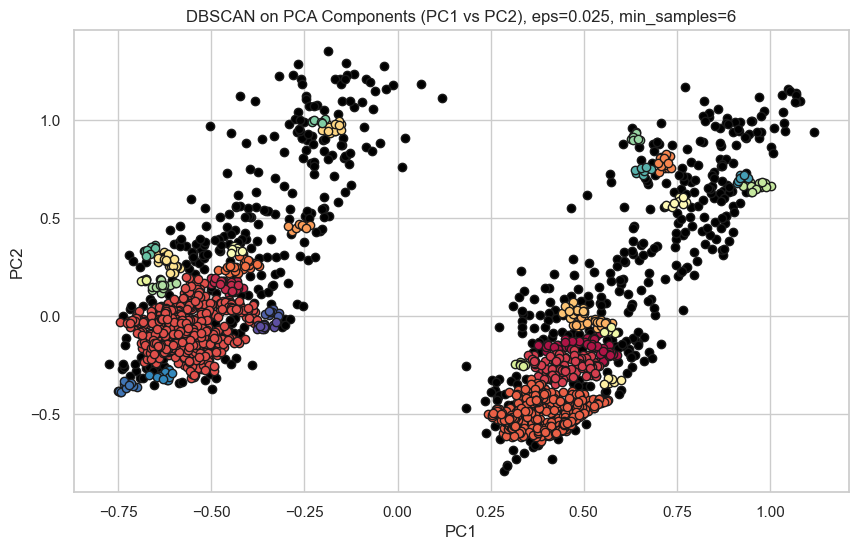


Applying DBSCAN with eps=0.025 and min_samples=8
Unique Cluster Labels (including noise): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
-1     753
 2     573
 3     429
 7      49
 16     31
 0      23
 11     23
 10     19
 1      16
 5      15
 8      13
 12     13
 4      13
 22     13
 13     12
 19     12
 17     12
 15     11
 9      11
 18     11
 6      10
 21     10
 20      9
 14      6
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 23
Silhouette Score: -0.1204
Davies-Bouldin Index: 1.1277
Calinski-Harabasz Index: 128.4172


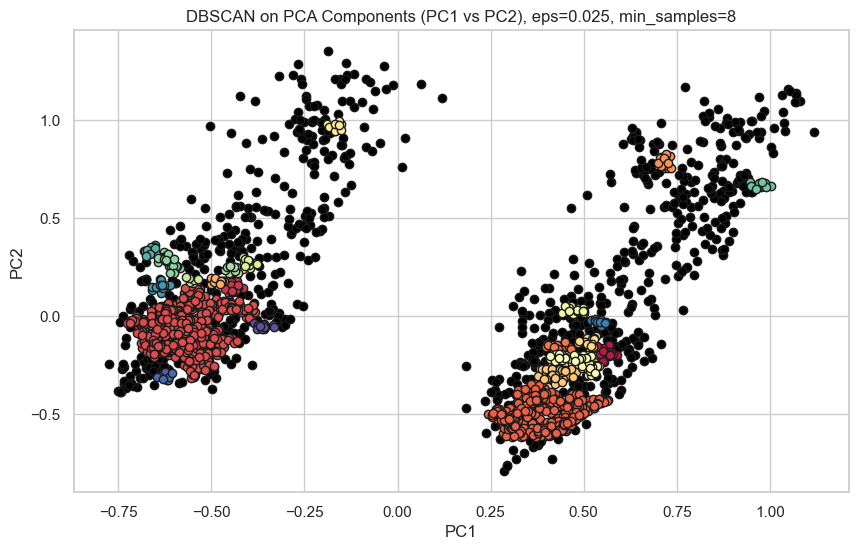


Applying DBSCAN with eps=0.025 and min_samples=10
Unique Cluster Labels (including noise): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
-1     948
 3     471
 2     419
 9      48
 6      45
 7      31
 0      19
 1      16
 8      16
 11     15
 4      13
 13     13
 10     12
 12     11
 5      10
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 14
Silhouette Score: -0.0830
Davies-Bouldin Index: 1.1399
Calinski-Harabasz Index: 144.3739


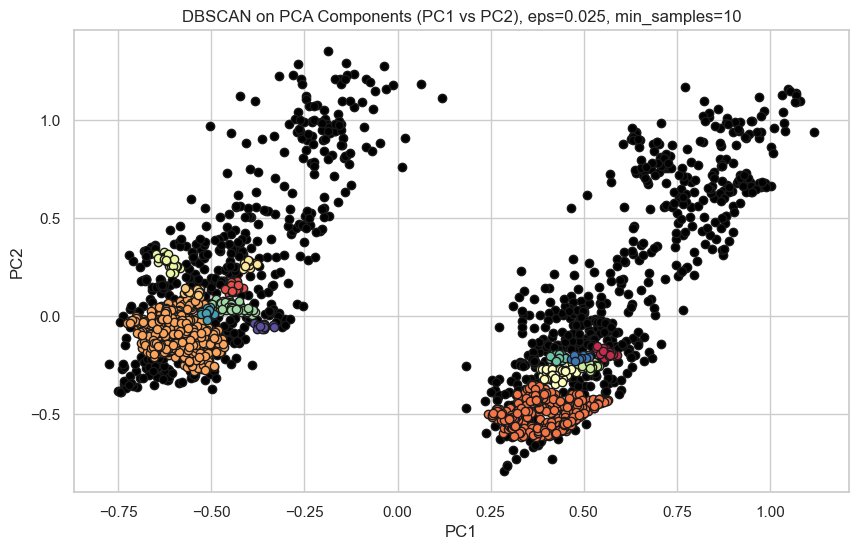

In [12]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to apply PCA on dataset
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return pca_df

# Function to apply DBSCAN and calculate evaluation metrics
def apply_dbscan_on_pca(pca_df, eps_value, min_samples_value, pc1='PC1', pc2='PC2'):
    """
    Applies DBSCAN on PCA components and evaluates clustering performance.
    Args:
        pca_df (DataFrame): PCA-transformed dataset.
        eps_value (float): DBSCAN epsilon value.
        min_samples_value (int): DBSCAN minimum samples value.
        pc1 (str): First principal component for visualization.
        pc2 (str): Second principal component for visualization.
    """
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    clusters = dbscan.fit_predict(pca_df[[pc1, pc2]])

    # Add the cluster labels to the PCA DataFrame
    pca_df['Cluster'] = clusters

    # Identify unique clusters (excluding noise -1)
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters[unique_clusters != -1])  # Exclude noise
    cluster_counts = pca_df['Cluster'].value_counts()

    print(f"Unique Cluster Labels (including noise): {unique_clusters}")
    print(cluster_counts)
    print(f"Number of Clusters (excluding noise): {n_clusters}")

    # Evaluation metrics
    if n_clusters > 1:
        # Silhouette Score
        silhouette_avg = silhouette_score(pca_df[[pc1, pc2]], clusters)
        print(f"Silhouette Score: {silhouette_avg:.4f}")

        # Davies-Bouldin Index
        db_index = davies_bouldin_score(pca_df[[pc1, pc2]], clusters)
        print(f"Davies-Bouldin Index: {db_index:.4f}")

        # Calinski-Harabasz Index (Variance Ratio Criterion)
        ch_index = calinski_harabasz_score(pca_df[[pc1, pc2]], clusters)
        print(f"Calinski-Harabasz Index: {ch_index:.4f}")
    else:
        print("Not enough clusters to calculate metrics.")

    # Visualize the clusters on the first two principal components
    plt.figure(figsize=(10, 6))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    for k, col in zip(unique_clusters, colors):
        if k == -1:
            # Noise points plotted in black
            col = [0, 0, 0, 1]

        class_member_mask = (clusters == k)
        xy = pca_df[class_member_mask]
        plt.plot(xy[pc1], xy[pc2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title(f'DBSCAN on PCA Components ({pc1} vs {pc2}), eps={eps_value}, min_samples={min_samples_value}')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.grid(True)
    plt.show()

# Function to experiment with DBSCAN parameters
def experiment_with_dbscan(pca_df, eps_values, min_samples_values):
    """
    Runs DBSCAN with different parameter combinations and evaluates results.
    Args:
        pca_df (DataFrame): PCA-transformed dataset.
        eps_values (list): List of epsilon values for DBSCAN.
        min_samples_values (list): List of min_samples values for DBSCAN.
    """
    for eps in eps_values:
        for min_samples in min_samples_values:
            print(f"\nApplying DBSCAN with eps={eps} and min_samples={min_samples}")
            apply_dbscan_on_pca(pca_df, eps_value=eps, min_samples_value=min_samples)

# Apply PCA
pca_df = pca_selection(df)

# Define parameter ranges
eps_values = [0.3, 0.5, 1.7, 0.025]
min_samples_values = [3, 6, 8, 10]

# Run DBSCAN experiments
experiment_with_dbscan(pca_df, eps_values, min_samples_values)


# 1. Effect of eps and min_samples:
Increasing eps:

As eps increases, the neighborhood radius for considering points as part of a cluster grows.
With small eps (e.g., eps=0.025), DBSCAN identifies many small clusters (e.g., 60 clusters with min_samples=3) as points are tightly grouped into local regions.
With large eps (e.g., eps=1.7), all points are merged into one large cluster, failing to distinguish meaningful structures.

Increasing min_samples:

A larger min_samples requires more points to form a cluster.
This reduces the number of small clusters, especially for datasets with noise or sparse regions.
For eps=0.025, the number of clusters drops from 60 (with min_samples=3) to 14 (with min_samples=10).
Higher min_samples values often result in a more conservative clustering but may exclude smaller meaningful clusters.


# Best DBSCAN Clustering 

Parameters: eps=0.3 or eps=0.5 with any min_samples value.
Reasoning:

Produces 2 clusters, which are consistent across these setups.

High Silhouette Score (0.5968), low DBI (0.7052), and high CHI (2709.6116) suggest optimal separation and compactness.


Applying DBSCAN with eps=0.3 and min_samples=10
Unique Cluster Labels (including noise): [0 1]
1    1052
0    1035
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5968
Davies-Bouldin Index: 0.7052
Calinski-Harabasz Index: 2709.6116


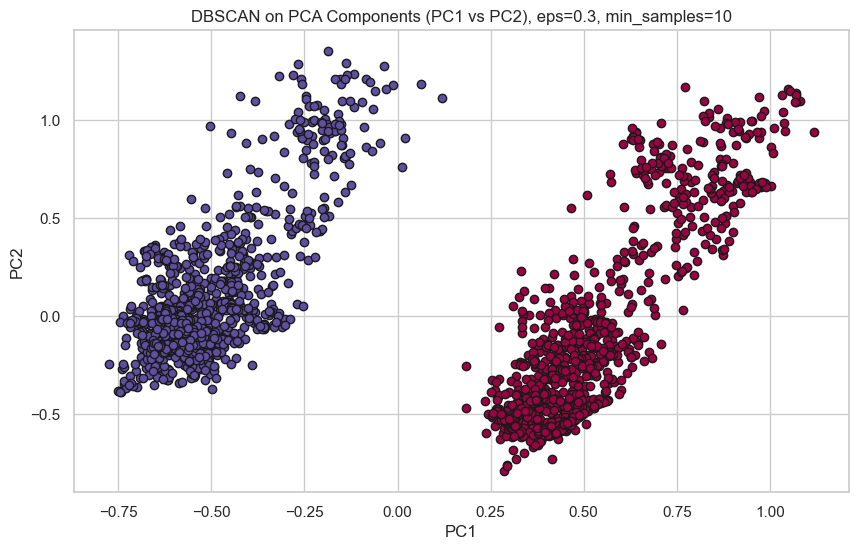

In [13]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to apply PCA on dataset
def pca_selection(df):
    """
    Applies PCA on the dataset after encoding categorical features.
    Args:
        df (DataFrame): Input dataset.
    Returns:
        DataFrame: Transformed dataset with PCA components.
    """
    # Ensure all categorical columns are encoded
    cat_var = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    if cat_var:
        label_encoder = LabelEncoder()
        for feature in cat_var:
            df[feature] = label_encoder.fit_transform(df[feature])

    # Apply PCA
    pca = PCA(random_state=123)
    pca_result = pca.fit_transform(df)

    # Create a DataFrame for PCA components
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    return pca_df

# Function to apply DBSCAN and calculate evaluation metrics
def apply_dbscan_on_pca(pca_df, eps_value, min_samples_value, pc1='PC1', pc2='PC2'):
    """
    Applies DBSCAN on PCA components and evaluates clustering performance.
    Args:
        pca_df (DataFrame): PCA-transformed dataset.
        eps_value (float): DBSCAN epsilon value.
        min_samples_value (int): DBSCAN minimum samples value.
        pc1 (str): First principal component for visualization.
        pc2 (str): Second principal component for visualization.
    """
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    clusters = dbscan.fit_predict(pca_df[[pc1, pc2]])

    # Add the cluster labels to the PCA DataFrame
    pca_df['Cluster'] = clusters

    # Identify unique clusters (excluding noise -1)
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters[unique_clusters != -1])  # Exclude noise
    cluster_counts = pca_df['Cluster'].value_counts()

    print(f"Unique Cluster Labels (including noise): {unique_clusters}")
    print(cluster_counts)
    print(f"Number of Clusters (excluding noise): {n_clusters}")

    # Evaluation metrics
    if n_clusters > 1:
        # Silhouette Score
        silhouette_avg = silhouette_score(pca_df[[pc1, pc2]], clusters)
        print(f"Silhouette Score: {silhouette_avg:.4f}")

        # Davies-Bouldin Index
        db_index = davies_bouldin_score(pca_df[[pc1, pc2]], clusters)
        print(f"Davies-Bouldin Index: {db_index:.4f}")

        # Calinski-Harabasz Index (Variance Ratio Criterion)
        ch_index = calinski_harabasz_score(pca_df[[pc1, pc2]], clusters)
        print(f"Calinski-Harabasz Index: {ch_index:.4f}")
    else:
        print("Not enough clusters to calculate metrics.")

    # Visualize the clusters on the first two principal components
    plt.figure(figsize=(10, 6))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    for k, col in zip(unique_clusters, colors):
        if k == -1:
            # Noise points plotted in black
            col = [0, 0, 0, 1]

        class_member_mask = (clusters == k)
        xy = pca_df[class_member_mask]
        plt.plot(xy[pc1], xy[pc2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title(f'DBSCAN on PCA Components ({pc1} vs {pc2}), eps={eps_value}, min_samples={min_samples_value}')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.grid(True)
    plt.show()

# Function to experiment with DBSCAN parameters
def experiment_with_dbscan(pca_df, eps_values, min_samples_values):
    """
    Runs DBSCAN with different parameter combinations and evaluates results.
    Args:
        pca_df (DataFrame): PCA-transformed dataset.
        eps_values (list): List of epsilon values for DBSCAN.
        min_samples_values (list): List of min_samples values for DBSCAN.
    """
    for eps in eps_values:
        for min_samples in min_samples_values:
            print(f"\nApplying DBSCAN with eps={eps} and min_samples={min_samples}")
            apply_dbscan_on_pca(pca_df, eps_value=eps, min_samples_value=min_samples)

# Apply PCA
pca_df = pca_selection(df)

# Define parameter ranges
eps_values = [0.3]
min_samples_values = [10]

# Run DBSCAN experiments
experiment_with_dbscan(pca_df, eps_values, min_samples_values)


In [27]:
# Sample DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=10)
df['DBSCAN_Cluster'] = dbscan.fit_predict(df)


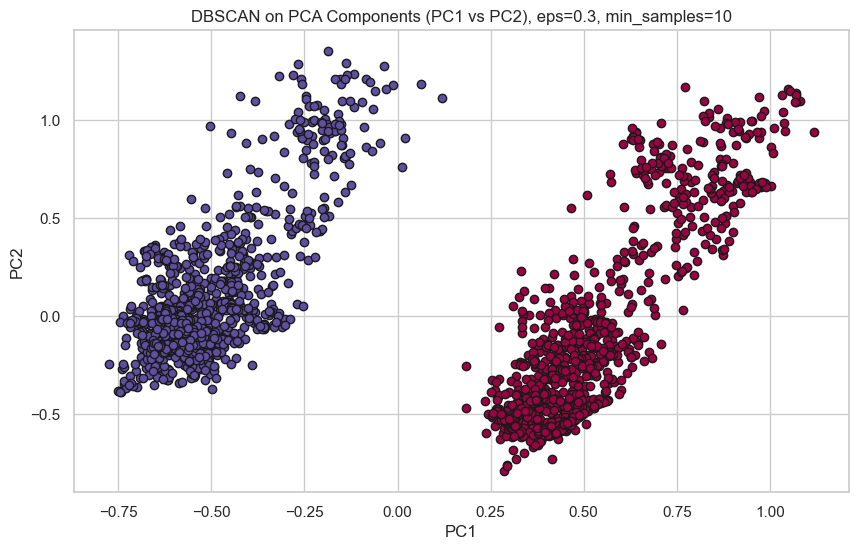

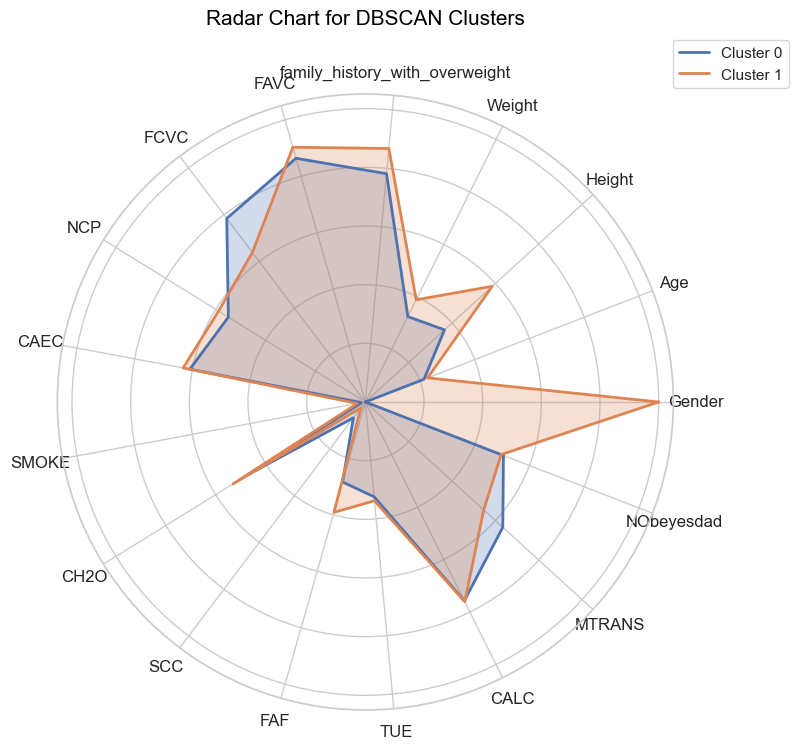

In [40]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Apply DBSCAN and calculate evaluation metrics
def apply_dbscan_on_pca(pca_df, eps_value, min_samples_value, pc1='PC1', pc2='PC2'):
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    clusters = dbscan.fit_predict(pca_df[[pc1, pc2]])

    # Add the cluster labels to the PCA DataFrame
    pca_df['Cluster'] = clusters

    # Visualize the clusters on the first two principal components
    plt.figure(figsize=(10, 6))
    unique_clusters = np.unique(clusters)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    for k, col in zip(unique_clusters, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Noise points in black
        class_member_mask = (clusters == k)
        xy = pca_df[class_member_mask]
        plt.plot(xy[pc1], xy[pc2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title(f'DBSCAN on PCA Components ({pc1} vs {pc2}), eps={eps_value}, min_samples={min_samples_value}')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.grid(True)
    plt.show()

    # Return the cluster labels
    return clusters

# Applying DBSCAN and adding clusters to df1
clusters = apply_dbscan_on_pca(pca_df, eps_value=0.3, min_samples_value=10)
df1['DBSCAN_Cluster'] = clusters  # Add the cluster labels as a new column in df1

# Function to create a radar chart for a given cluster type
def plot_radar_chart(df, cluster_column, title='Radar Chart'):
    # Calculate the mean of each feature by cluster
    cluster_means = df.groupby(cluster_column).mean()
    
    # Define labels (features) and number of variables
    labels = cluster_means.columns
    num_vars = len(labels)
    
    # Setup angles for radar chart (spaced equally around a circle)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # The plot needs to be a complete loop, so we repeat the first angle at the end
    angles += angles[:1]
    
    # Plotting radar chart for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot each cluster
    for idx, row in cluster_means.iterrows():
        values = row.tolist()
        values += values[:1]  # Complete the loop by adding the start value at the end
        ax.plot(angles, values, label=f'Cluster {idx}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    # Set up chart attributes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    plt.show()

# Radar chart for DBSCAN clusters
plot_radar_chart(df1, 'DBSCAN_Cluster', title='Radar Chart for DBSCAN Clusters')


Cluster 0: The polygon for Cluster 0 is larger in the "Family History with Overweight" and "Weight" dimensions, suggesting that individuals in this cluster are more likely to have a family history of overweight and weigh more.

Cluster 1: The polygon for Cluster 1 is larger in the "Age" and "Gender" dimensions, suggesting that individuals in this cluster might be older or have a different gender distribution compared to Cluster 0.

# OPTICS CLUSTERING

Unique Cluster Labels (including noise): [-1  0]
-1    1056
 0    1031
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 1
Silhouette Score: 0.5891
Davies-Bouldin Index: 0.7178
Calinski-Harabasz Index: 2540.1477


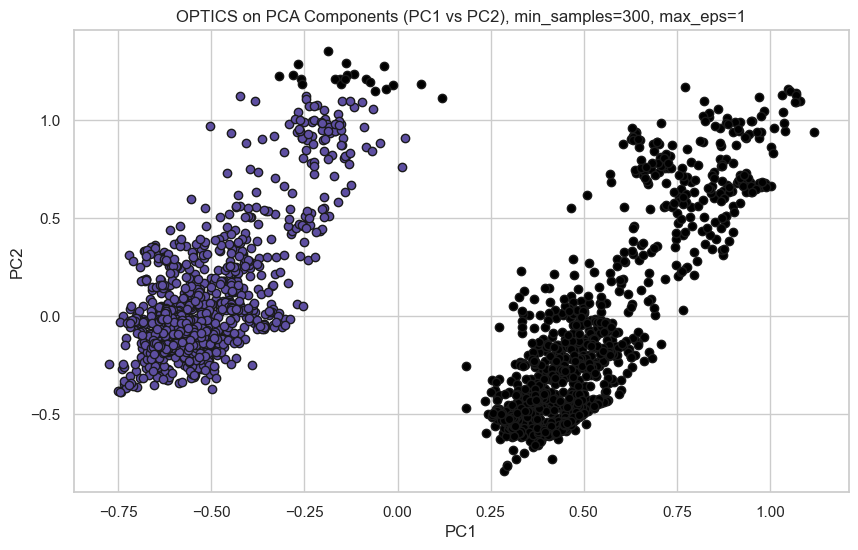

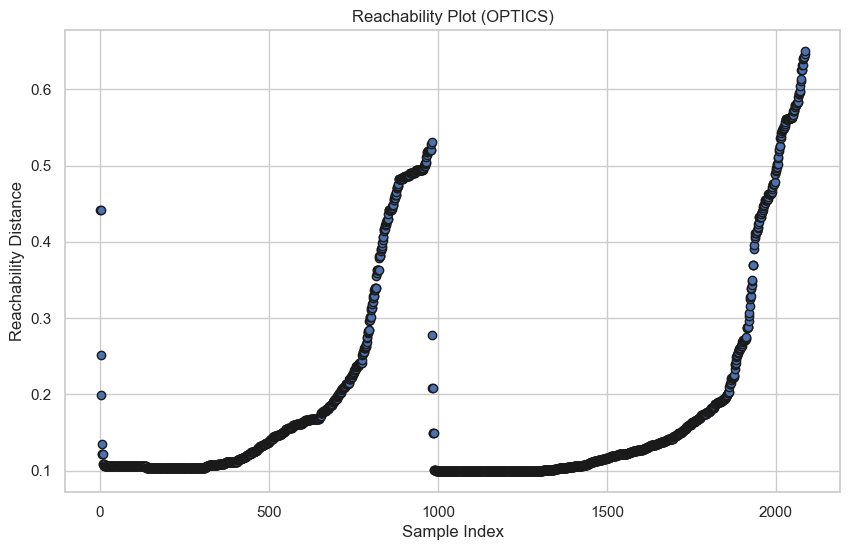

Unique Cluster Labels (including noise): [-1  0  1]
 1    1022
 0     962
-1     103
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5704
Davies-Bouldin Index: 0.6356
Calinski-Harabasz Index: 2206.4920


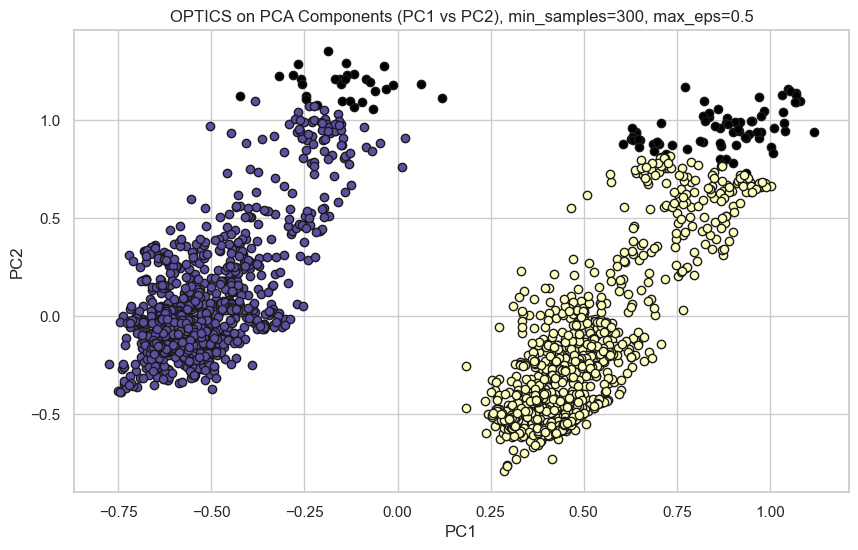

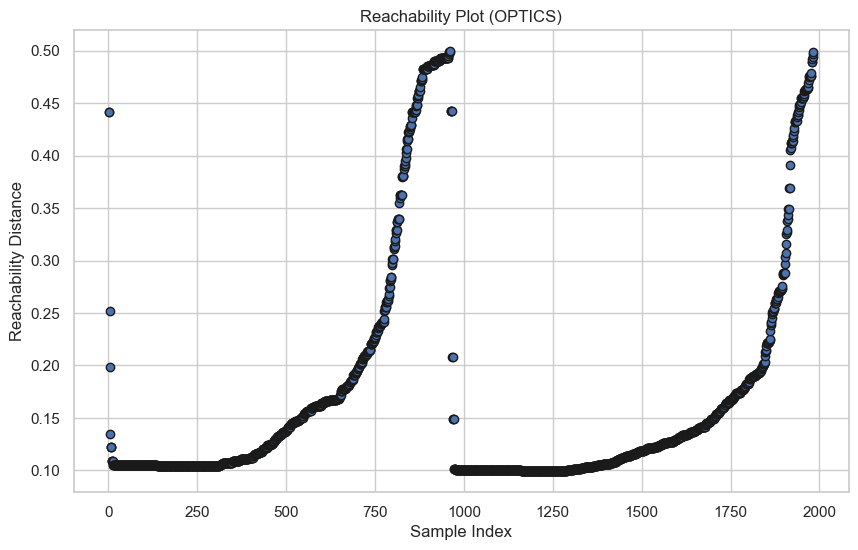

Unique Cluster Labels (including noise): [-1]
-1    2087
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 0
Not enough clusters to calculate metrics.


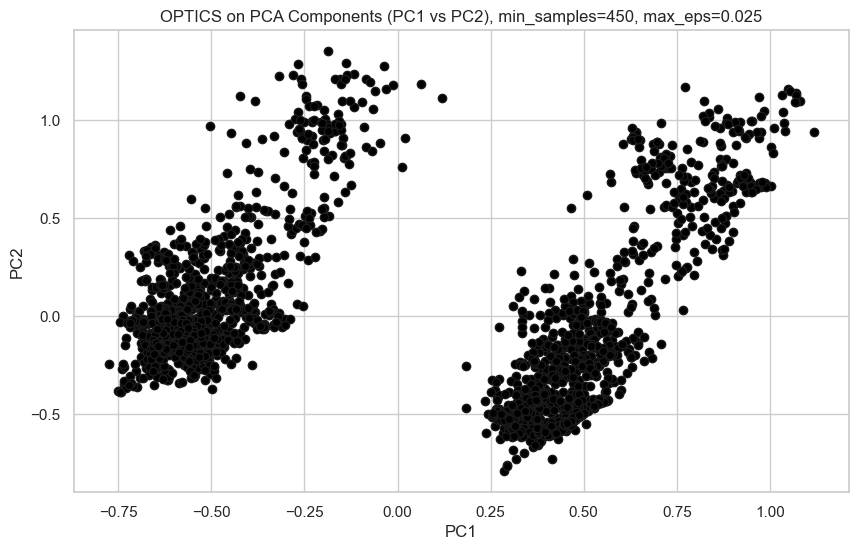

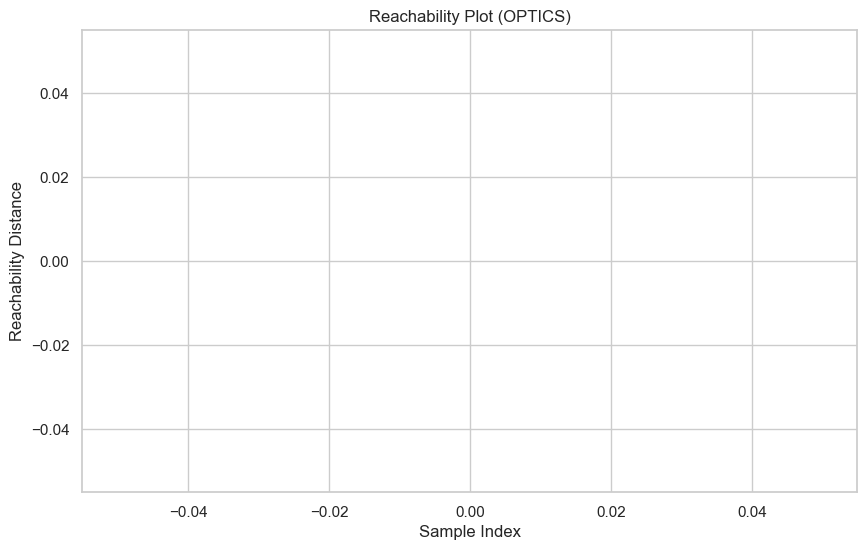

Unique Cluster Labels (including noise): [-1]
-1    2087
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 0
Not enough clusters to calculate metrics.


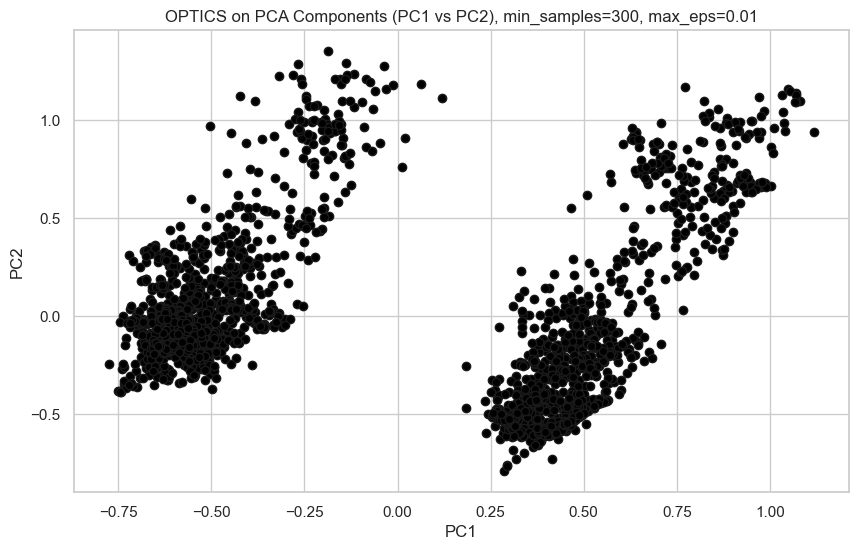

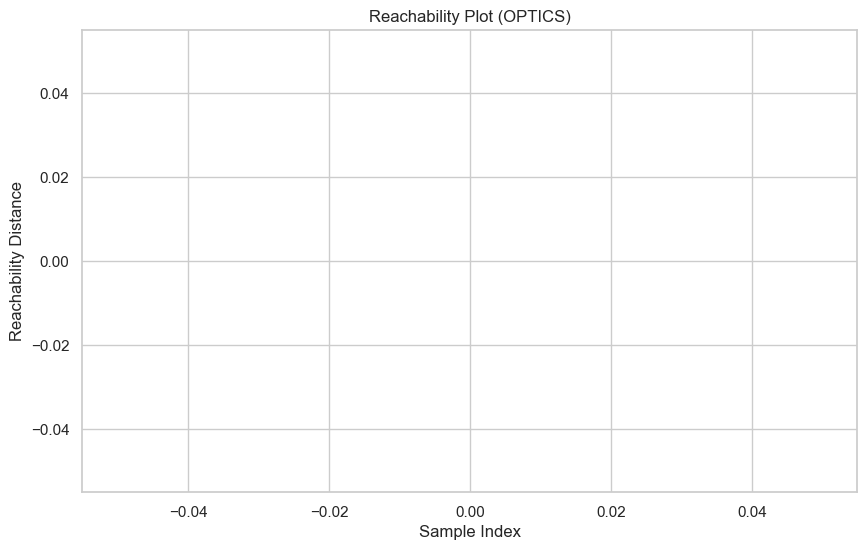

In [46]:
import numpy as np
import pandas as pd
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

def optics(pca_df, min_samples_value, max_eps_value, pc1='PC1', pc2='PC2'):
    # Apply OPTICS clustering with the given parameters
    optics = OPTICS(min_samples=min_samples_value, max_eps=max_eps_value)
    clusters = optics.fit_predict(pca_df[[pc1, pc2]])

    # Add the cluster labels to the PCA DataFrame
    pca_df['Cluster'] = clusters

    # Identify unique clusters (excluding noise -1)
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters[unique_clusters != -1])  # Exclude noise
    cluster_counts = pca_df['Cluster'].value_counts()

    # Print the cluster labels and number of clusters
    print(f"Unique Cluster Labels (including noise): {unique_clusters}")
    print(cluster_counts)
    print(f"Number of Clusters (excluding noise): {n_clusters}")

    # Evaluation metrics (when there are multiple clusters and not all data points are noise)
    if len(set(clusters)) > 1 and len(set(clusters)) < len(pca_df):  
        # Silhouette Score
        silhouette_avg = silhouette_score(pca_df[[pc1, pc2]], clusters)
        print(f"Silhouette Score: {silhouette_avg:.4f}")

        # Davies-Bouldin Index
        db_index = davies_bouldin_score(pca_df[[pc1, pc2]], clusters)
        print(f"Davies-Bouldin Index: {db_index:.4f}")

        # Calinski-Harabasz Index
        ch_index = calinski_harabasz_score(pca_df[[pc1, pc2]], clusters)
        print(f"Calinski-Harabasz Index: {ch_index:.4f}")
    
    else:
        print("Not enough clusters to calculate metrics.")

    # Visualize the clusters on the first two principal components
    plt.figure(figsize=(10, 6))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    for k, col in zip(unique_clusters, colors):
        if k == -1:
            # Noise points plotted in black
            col = [0, 0, 0, 1]

        class_member_mask = (clusters == k)

        xy = pca_df[class_member_mask]
        plt.plot(xy[pc1], xy[pc2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title(f'OPTICS on PCA Components ({pc1} vs {pc2}), min_samples={min_samples_value}, max_eps={max_eps_value}')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.grid(True)
    plt.show()

    # Reachability plot
    plt.figure(figsize=(10, 6))
    space = np.arange(len(pca_df))
    reachability = optics.reachability_[optics.ordering_]

    plt.plot(space, reachability, 'o', markerfacecolor='b', markeredgecolor='k', markersize=6)
    plt.title('Reachability Plot (OPTICS)')
    plt.xlabel('Sample Index')
    plt.ylabel('Reachability Distance')
    plt.grid(True)
    plt.show()

# Experiment with the specified min_samples and eps values:
optics(pca_df, min_samples_value=300, max_eps_value=1)
optics(pca_df, min_samples_value=300, max_eps_value=0.5)
optics(pca_df, min_samples_value=450, max_eps_value=0.025)
optics(pca_df, min_samples_value=300, max_eps_value=0.01)

# EFFECT OF EPs and Samples

We can see that if increase the value of eps single huge cluster is formed while if decrease noticebilty there is huge effect optics might not find clusters 

Unique Cluster Labels (including noise): [-1  0  1]
 1    1022
 0     962
-1     103
Name: Cluster, dtype: int64
Number of Clusters (excluding noise): 2
Silhouette Score: 0.5704
Davies-Bouldin Index: 0.6356
Calinski-Harabasz Index: 2206.4920


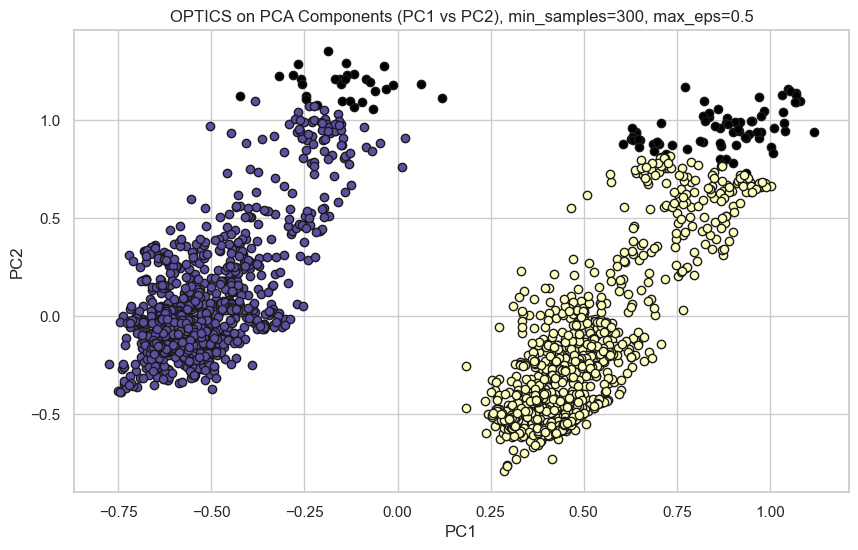

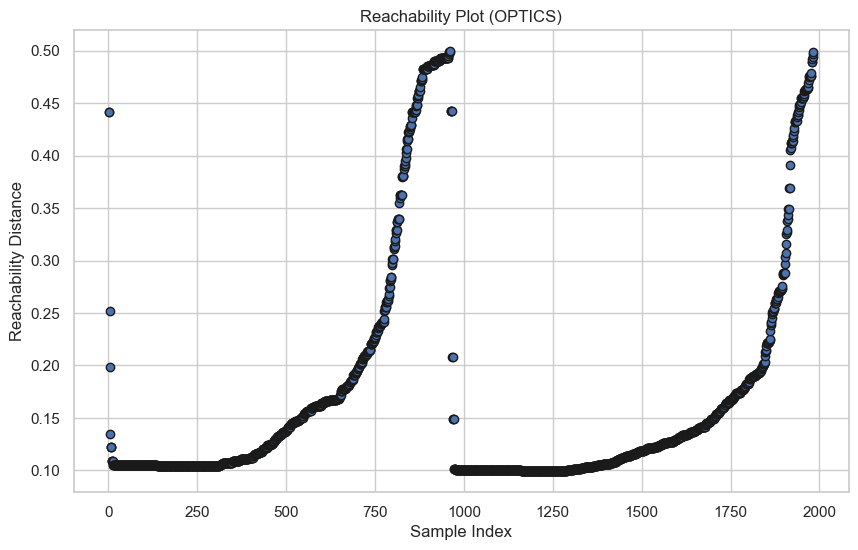

In [47]:
optics(pca_df, min_samples_value=300, max_eps_value=0.5)

# RADAR PLOT FOR OPTICS

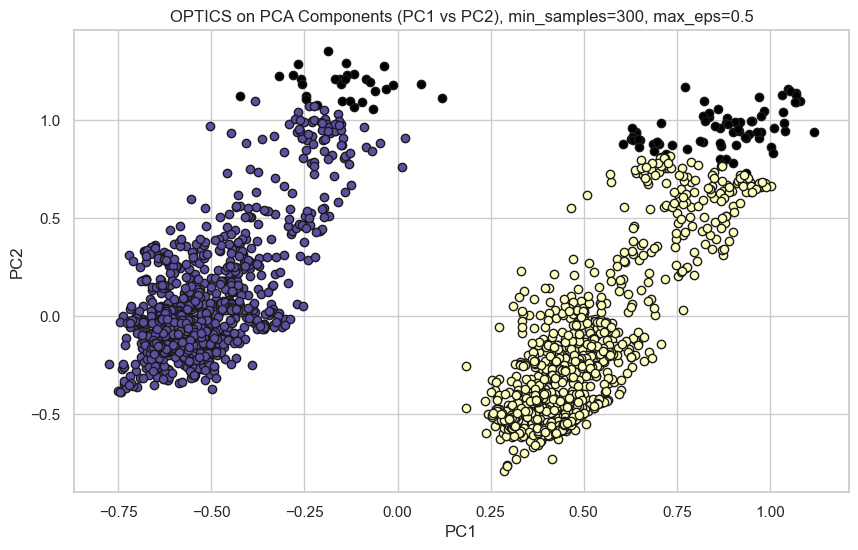

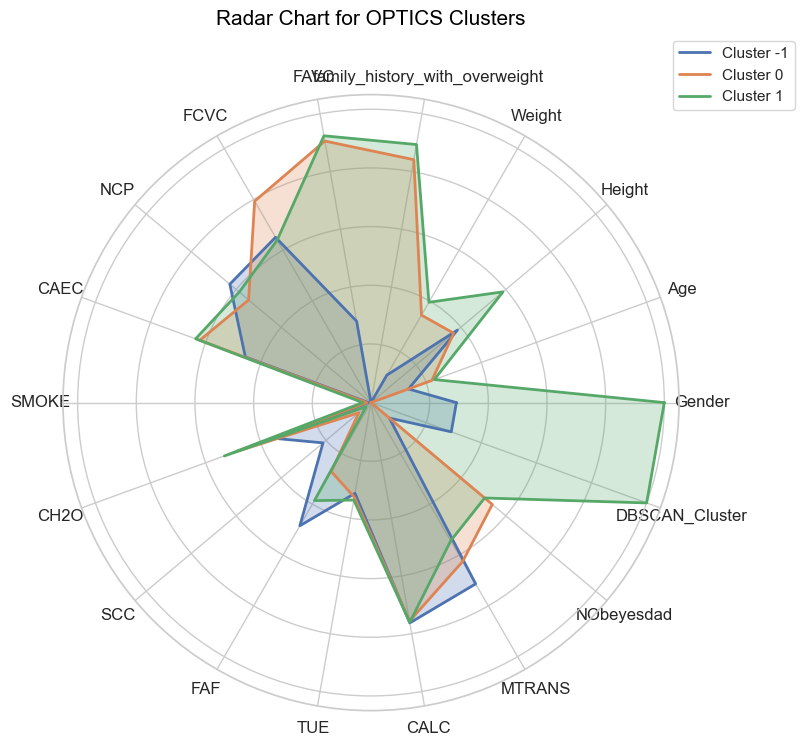

In [48]:
import numpy as np
import pandas as pd
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt

# Apply OPTICS and calculate evaluation metrics
def apply_optics_on_pca(pca_df, min_samples_value, max_eps_value, pc1='PC1', pc2='PC2'):
    optics = OPTICS(min_samples=min_samples_value, max_eps=max_eps_value)
    clusters = optics.fit_predict(pca_df[[pc1, pc2]])

    # Add the cluster labels to the PCA DataFrame
    pca_df['Cluster'] = clusters

    # Visualize the clusters on the first two principal components
    plt.figure(figsize=(10, 6))
    unique_clusters = np.unique(clusters)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_clusters))]

    for k, col in zip(unique_clusters, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Noise points in black
        class_member_mask = (clusters == k)
        xy = pca_df[class_member_mask]
        plt.plot(xy[pc1], xy[pc2], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title(f'OPTICS on PCA Components ({pc1} vs {pc2}), min_samples={min_samples_value}, max_eps={max_eps_value}')
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.grid(True)
    plt.show()

    # Return the cluster labels
    return clusters

# Applying OPTICS and adding clusters to df1
clusters = apply_optics_on_pca(pca_df, min_samples_value=300, max_eps_value=0.5)
df1['OPTICS_Cluster'] = clusters  # Add the cluster labels as a new column in df1

# Radar chart for OPTICS clusters
def plot_radar_chart(df, cluster_column, title='Radar Chart'):
    # Calculate the mean of each feature by cluster
    cluster_means = df.groupby(cluster_column).mean()
    
    # Define labels (features) and number of variables
    labels = cluster_means.columns
    num_vars = len(labels)
    
    # Setup angles for radar chart (spaced equally around a circle)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # The plot needs to be a complete loop, so we repeat the first angle at the end
    angles += angles[:1]
    
    # Plotting radar chart for each cluster
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot each cluster
    for idx, row in cluster_means.iterrows():
        values = row.tolist()
        values += values[:1]  # Complete the loop by adding the start value at the end
        ax.plot(angles, values, label=f'Cluster {idx}', linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    # Set up chart attributes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels([])
    ax.set_title(title, size=15, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    plt.show()

# Radar chart for OPTICS clusters
plot_radar_chart(df1, 'OPTICS_Cluster', title='Radar Chart for OPTICS Clusters')


# CONCLUSION
Based on the results, we can conclude that OPTICS is performing well compared to DBSCAN, as it effectively identifies three distinct clusters, which aligns with the business knowledge and the three predefined labels in the dataset. This suggests that OPTICS is able to capture the underlying structure of the data more accurately in this context